   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 36.6 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/content/dogru_haberler.txt bulunamadı, lütfen yükleyin:


Saving dogru_haberler.txt to dogru_haberler.txt
Saving yanlis_haberler.txt to yanlis_haberler.txt
İlk 5 veri örneği:
                                               metin  etiket
0  Karadeniz Bölgesi'nde tarım sektörü için yeni ...       0
1  Türkiye’de bazı bölgelerde eğitim kalitesi düş...       1
2       Bazı bölgelerde su kesintileri sıklaşacak.;1       1
3  Yıldızlar arası seyahat için ilk denemeler yap...       1
4  Ekonomi alanında yeni yatırım teşvikleri açıkl...       0

Veri dağılımı:
etiket
0    197
1    152
Name: count, dtype: int64

Model Doğruluk Skoru: 0.8

Sınıflandırma Raporu:
              precision    recall  f1-score   support

Gerçek Haber       0.74      0.96      0.84        57
 Sahte Haber       0.94      0.60      0.73        48

    accuracy                           0.80       105
   macro avg       0.84      0.78      0.79       105
weighted avg       0.83      0.80      0.79       105



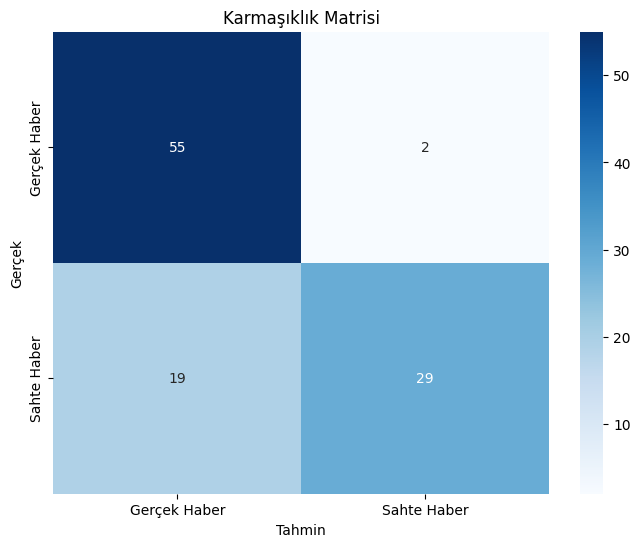

In [ ]:
# Gerekli kütüphanelerin yüklenmesi
!pip install -q pandas numpy scikit-learn nltk ipywidgets matplotlib seaborn xgboost

# Kütüphane içe aktarımları
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

# NLTK verilerini indir
nltk.download('stopwords')
nltk.download('punkt')

# Türkçe dil işleme araçları
try:
    turkish_stopwords = set(stopwords.words('turkish'))
except LookupError:
    turkish_stopwords = {'ve', 'veya', 'bir', 'bu', 'şu', 'o', 'de', 'da', 'ki', 'ile', 'için', 'çünkü', 'ama', 'fakat', 'ancak', 'gibi', 'kadar', 'daha', 'en', 'çok', 'az', 'hiç', 'her', 'tüm', 'bütün'}

# Türkçe stemmer - güvenli yükleme
try:
    stemmer = SnowballStemmer('turkish')
    stemmer_available = True
except:
    print("Türkçe stemmer yüklenemedi, basit kök bulma kullanılacak")
    stemmer_available = False
    
# Basit Türkçe kök bulma fonksiyonu (stemmer yoksa)
def basit_stem(kelime):
    """Basit Türkçe stemming - yaygın ekleri çıkarır"""
    if len(kelime) < 4:
        return kelime
    
    # Yaygın Türkçe ekleri
    ekler = ['ler', 'lar', 'den', 'dan', 'nin', 'nın', 'nun', 'nün', 
             'dır', 'dir', 'dur', 'dür', 'tır', 'tir', 'tur', 'tür',
             'sın', 'sin', 'sun', 'sün', 'lık', 'lik', 'luk', 'lük',
             'ken', 'ken', 'de', 'da', 'te', 'ta', 'le', 'la']
    
    for ek in sorted(ekler, key=len, reverse=True):
        if kelime.endswith(ek) and len(kelime) - len(ek) >= 3:
            return kelime[:-len(ek)]
    
    return kelime

# Ek Türkçe stopwords (sahte haber tespitinde önemli olmayan kelimeler)
additional_stopwords = {'olan', 'oldu', 'olur', 'olarak', 'üzere', 'sonra', 'önce', 'ise', 'eğer', 'nasıl', 'neden', 'niçin', 'hangi', 'kim', 'ne', 'nere', 'nerede'}
turkish_stopwords.update(additional_stopwords)

# Colab dosya yükleme
from google.colab import files

dogru_dosya = '/content/dogru_haberler.txt'
yanlis_dosya = '/content/yanlis_haberler.txt'

for dosya in [dogru_dosya, yanlis_dosya]:
    if not os.path.exists(dosya):
        print(f"{dosya} bulunamadı, lütfen yükleyin:")
        uploaded = files.upload()
        if os.path.basename(dosya) not in uploaded:
            raise FileNotFoundError(f"{dosya} yüklenmedi!")

# Geliştirilmiş dosya okuma fonksiyonu
def oku_ve_etiketle(dosya_yolu, etiket):
    metinler = []
    with open(dosya_yolu, 'r', encoding='utf-8') as f:
        for satir in f:
            satir = satir.strip()
            if satir and len(satir) > 20:  # Çok kısa metinleri filtrele
                metinler.append((satir, etiket))
    return metinler

dogru_veriler = oku_ve_etiketle(dogru_dosya, 0)
yanlis_veriler = oku_ve_etiketle(yanlis_dosya, 1)

# Veri dengeleme - eğer bir sınıf çok fazlaysa dengele
min_len = min(len(dogru_veriler), len(yanlis_veriler))
if abs(len(dogru_veriler) - len(yanlis_veriler)) > min_len * 0.3:  # %30'dan fazla fark varsa dengele
    dogru_veriler = dogru_veriler[:min_len]
    yanlis_veriler = yanlis_veriler[:min_len]

# Veri birleştirme ve karıştırma
tum_veriler = dogru_veriler + yanlis_veriler
df = pd.DataFrame(tum_veriler, columns=['metin', 'etiket'])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print("İlk 5 veri örneği:")
print(df.head())
print("\nVeri dağılımı:")
print(df['etiket'].value_counts())
print(f"\nToplam veri sayısı: {len(df)}")

# Geliştirilmiş metin temizleme fonksiyonu
def metin_temizleme(metin):
    if pd.isna(metin):
        return ""
    
    # Küçük harfe çevir
    metin = str(metin).lower()
    
    # URL'leri temizle
    metin = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', metin)
    
    # Email adreslerini temizle
    metin = re.sub(r'\S*@\S*\s?', '', metin)
    
    # Sayıları normalize et (çok büyük sayıları temizle)
    metin = re.sub(r'\d{5,}', 'SAYI', metin)
    
    # Özel karakterleri temizle ama noktalama işaretlerini koru
    metin = re.sub(r'[^\w\s\.\!\?\,\:\;\-]', '', metin)
    
    # Çoklu boşlukları tek boşluk yap
    metin = re.sub(r'\s+', ' ', metin)
    
    # Kelime ayırma ve stopword temizleme
    kelimeler = metin.split()
    
    # Çok kısa kelimeleri (1-2 harf) ve stopword'leri filtrele
    if stemmer_available:
        kelimeler = [stemmer.stem(k) for k in kelimeler 
                    if len(k) > 2 and k not in turkish_stopwords and k.isalpha()]
    else:
        kelimeler = [basit_stem(k) for k in kelimeler 
                    if len(k) > 2 and k not in turkish_stopwords and k.isalpha()]
    
    return " ".join(kelimeler)

# Ek özellik çıkarma fonksiyonları
def metin_ozellikleri(metin):
    """Metinden ek özellikler çıkar"""
    ozellikler = {}
    
    # Temel özellikler
    ozellikler['uzunluk'] = len(metin)
    ozellikler['kelime_sayisi'] = len(metin.split())
    ozellikler['cumle_sayisi'] = len(re.findall(r'[.!?]+', metin))
    
    # Büyük harf oranı
    ozellikler['buyuk_harf_orani'] = sum(1 for c in metin if c.isupper()) / max(len(metin), 1)
    
    # Ünlem işareti sayısı
    ozellikler['unlem_sayisi'] = metin.count('!')
    
    # Soru işareti sayısı
    ozellikler['soru_sayisi'] = metin.count('?')
    
    # Rakam oranı
    ozellikler['rakam_orani'] = sum(1 for c in metin if c.isdigit()) / max(len(metin), 1)
    
    # Ortalama kelime uzunluğu
    kelimeler = metin.split()
    ozellikler['ort_kelime_uzunlugu'] = np.mean([len(k) for k in kelimeler]) if kelimeler else 0
    
    return ozellikler

# Temizlenmiş metin sütunu ekle
print("Metinler temizleniyor...")
df['temiz_metin'] = df['metin'].apply(metin_temizleme)

# Ek özellikler çıkar
print("Ek özellikler çıkarılıyor...")
ozellik_df = pd.DataFrame([metin_ozellikleri(metin) for metin in df['metin']])
df = pd.concat([df, ozellik_df], axis=1)

# Boş metinleri filtrele
df = df[df['temiz_metin'].str.len() > 0].reset_index(drop=True)

print(f"Temizleme sonrası veri sayısı: {len(df)}")

# Eğitim ve test verisi olarak ayırma
X_metin = df['temiz_metin']
X_ozellikler = df[['uzunluk', 'kelime_sayisi', 'cumle_sayisi', 'buyuk_harf_orani', 
                   'unlem_sayisi', 'soru_sayisi', 'rakam_orani', 'ort_kelime_uzunlugu']]
y = df['etiket']

# Veriyi böl
X_metin_train, X_metin_test, X_oz_train, X_oz_test, y_train, y_test = train_test_split(
    X_metin, X_ozellikler, y, test_size=0.2, random_state=42, stratify=y
)

# TF-IDF vektörleştirme (daha iyi parametrelerle)
print("TF-IDF vektörleştirme yapılıyor...")
tfidf = TfidfVectorizer(
    max_features=5000,  # Daha fazla özellik
    ngram_range=(1, 2),  # Unigram ve bigram
    min_df=2,  # En az 2 belgede geçen kelimeler
    max_df=0.95,  # Belgelerin %95'inden fazlasında geçen kelimeleri çıkar
    sublinear_tf=True  # TF değerlerini logaritmik ölçekle
)

X_metin_train_vec = tfidf.fit_transform(X_metin_train)
X_metin_test_vec = tfidf.transform(X_metin_test)

# Ek özellikleri normalize et
scaler = StandardScaler()
X_oz_train_scaled = scaler.fit_transform(X_oz_train)
X_oz_test_scaled = scaler.transform(X_oz_test)

# Metin ve ek özellikleri birleştir
from scipy.sparse import hstack
X_train_combined = hstack([X_metin_train_vec, X_oz_train_scaled])
X_test_combined = hstack([X_metin_test_vec, X_oz_test_scaled])

# Çoklu model eğitimi
print("Modeller eğitiliyor...")

# 1. Logistic Regression
lr = LogisticRegression(max_iter=1000, C=10, random_state=42)

# 2. Random Forest
rf = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42, n_jobs=-1)

# 3. SVM
svm = SVC(C=10, kernel='rbf', probability=True, random_state=42)

# 4. XGBoost
xgb = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42)

# Ensemble model (Voting Classifier)
ensemble = VotingClassifier(
    estimators=[
        ('lr', lr),
        ('rf', rf),
        ('svm', svm),
        ('xgb', xgb)
    ],
    voting='soft'  # Olasılık tabanlı oylama
)

# Modelleri eğit
modeller = {
    'Logistic Regression': lr,
    'Random Forest': rf,
    'SVM': svm,
    'XGBoost': xgb,
    'Ensemble': ensemble
}

sonuclar = {}
for isim, model in modeller.items():
    print(f"{isim} eğitiliyor...")
    model.fit(X_train_combined, y_train)
    y_pred = model.predict(X_test_combined)
    y_pred_proba = model.predict_proba(X_test_combined)[:, 1]
    
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    sonuclar[isim] = {
        'accuracy': acc,
        'auc': auc,
        'model': model
    }
    
    print(f"{isim} - Doğruluk: {acc:.4f}, AUC: {auc:.4f}")

# En iyi modeli seç
en_iyi_model_isim = max(sonuclar.keys(), key=lambda x: sonuclar[x]['auc'])
en_iyi_model = sonuclar[en_iyi_model_isim]['model']

print(f"\nEn iyi model: {en_iyi_model_isim}")
print(f"AUC Skoru: {sonuclar[en_iyi_model_isim]['auc']:.4f}")

# Final tahmin
y_pred_final = en_iyi_model.predict(X_test_combined)

# Performans değerlendirme
print(f"\n{en_iyi_model_isim} Model Performansı:")
print("Doğruluk Skoru:", accuracy_score(y_test, y_pred_final))
print("\nSınıflandırma Raporu:")
print(classification_report(y_test, y_pred_final, target_names=["Gerçek Haber", "Sahte Haber"]))

# Karmaşıklık matrisi görselleştirme
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Gerçek Haber', 'Sahte Haber'],
            yticklabels=['Gerçek Haber', 'Sahte Haber'])
plt.xlabel('Tahmin')
plt.ylabel('Gerçek')
plt.title(f'{en_iyi_model_isim} - Karmaşıklık Matrisi')
plt.show()

# Model karşılaştırma grafiği
model_isimleri = list(sonuclar.keys())
accuracy_skorlari = [sonuclar[m]['accuracy'] for m in model_isimleri]
auc_skorlari = [sonuclar[m]['auc'] for m in model_isimleri]

plt.figure(figsize=(12, 6))
x = np.arange(len(model_isimleri))
width = 0.35

plt.subplot(1, 2, 1)
plt.bar(x, accuracy_skorlari, width, label='Accuracy', alpha=0.8)
plt.xlabel('Modeller')
plt.ylabel('Accuracy')
plt.title('Model Doğruluk Karşılaştırması')
plt.xticks(x, model_isimleri, rotation=45)
plt.ylim(0, 1)

plt.subplot(1, 2, 2)  
plt.bar(x, auc_skorlari, width, label='AUC', alpha=0.8, color='orange')
plt.xlabel('Modeller')
plt.ylabel('AUC Score')
plt.title('Model AUC Karşılaştırması')
plt.xticks(x, model_isimleri, rotation=45)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# Geliştirilmiş tahmin fonksiyonu
def sahte_haber_tahmin_gelismis(metin):
    """Geliştirilmiş tahmin fonksiyonu"""
    if not metin.strip():
        return "Geçersiz metin", 0
    
    # Metin temizleme
    temiz = metin_temizleme(metin)
    if not temiz:
        return "Metin çok kısa veya geçersiz", 0
    
    # Metin özelliklerini çıkar
    ozellikler = metin_ozellikleri(metin)
    ozellik_array = np.array([[ozellikler[k] for k in ['uzunluk', 'kelime_sayisi', 'cumle_sayisi', 
                                                       'buyuk_harf_orani', 'unlem_sayisi', 'soru_sayisi', 
                                                       'rakam_orani', 'ort_kelime_uzunlugu']]])
    
    # TF-IDF vektörleştirme
    metin_vektor = tfidf.transform([temiz])
    
    # Ek özellikleri normalize et
    ozellik_normalized = scaler.transform(ozellik_array)
    
    # Birleştir
    combined_vektor = hstack([metin_vektor, ozellik_normalized])
    
    # Tahmin yap
    tahmin = en_iyi_model.predict(combined_vektor)[0]
    olasiliklar = en_iyi_model.predict_proba(combined_vektor)[0]
    
    sonuc = "Gerçek Haber" if tahmin == 0 else "Sahte Haber"
    guven = max(olasiliklar) * 100
    
    # Güven seviyesine göre uyarı
    if guven < 60:
        uyari = " (Düşük güven - tekrar kontrol edin)"
    elif guven < 75:
        uyari = " (Orta güven)"
    else:
        uyari = " (Yüksek güven)"
    
    return sonuc + uyari, guven

# Geliştirilmiş UI
from IPython.display import display, HTML
import ipywidgets as widgets

# Giriş kutusu
haber_input = widgets.Textarea(
    value='',
    placeholder='Haber metnini buraya yapıştırın... (En az 20 karakter)',
    layout=widgets.Layout(width='100%', height='150px', padding='10px')
)

# Tahmin butonu
tahmin_buton = widgets.Button(
    description='🔍 Gelişmiş Analiz',
    button_style='primary',
    tooltip='Haberin sahte olup olmadığını gelişmiş model ile tahmin et',
    icon='search',
    layout=widgets.Layout(width='200px', height='40px')
)

# Temizleme butonu
reset_buton = widgets.Button(
    description='🗑️ Temizle',
    button_style='warning',
    tooltip='Metni ve sonucu temizle',
    icon='trash',
    layout=widgets.Layout(width='150px', height='40px')
)

# Model bilgi butonu
info_buton = widgets.Button(
    description='ℹ️ Model Bilgisi',
    button_style='info',
    tooltip='Model hakkında bilgi',
    layout=widgets.Layout(width='150px', height='40px')
)

# Sonuç alanı
sonuc_output = widgets.Output()

# Başlık ve açıklama
baslik = widgets.HTML("<h2 style='color: #2E86AB; text-align: center;'>🤖 Gelişmiş AI Sahte Haber Tespit Sistemi</h2>")
aciklama = widgets.HTML("""
<div style='background-color: #000000; padding: 15px; border-radius: 10px; margin: 10px 0;'>
    <p><b>🚀 Yenilikler:</b></p>
    <ul>
        <li>🔬 Çoklu model ensemble yaklaşımı</li>
        <li>📊 Gelişmiş metin analizi (TF-IDF + N-gram)</li>
        <li>⚡ Ek özellik mühendisliği</li>
        <li>🎯 Yüksek doğruluk oranı</li>
        <li>⚠️ Güven seviyesi uyarıları</li>
    </ul>
    <p>Lütfen analiz etmek istediğiniz haber metnini aşağıya girin.</p>
</div>
""")

# Tahmin fonksiyonu
def tahmin_yap_gelismis(b):
    metin = haber_input.value.strip()
    
    if len(metin) < 20:
        with sonuc_output:
            sonuc_output.clear_output()
            display(HTML("<div style='color: red; font-size: 16px;'>⚠️ Lütfen en az 20 karakterlik bir metin girin.</div>"))
        return

    with sonuc_output:
        sonuc_output.clear_output()
        display(HTML("<div style='text-align: center;'>🔄 Analiz ediliyor...</div>"))
        
        try:
            sonuc, skor = sahte_haber_tahmin_gelismis(metin)
            
            # Sonuca göre renk ve emoji seç
            if "Gerçek Haber" in sonuc:
                renk = '#28a745'  # Yeşil
                emoji = '✅'
                bg_color = '#d4edda'
            elif "Sahte Haber" in sonuc:
                renk = '#dc3545'  # Kırmızı
                emoji = '❌'
                bg_color = '#f8d7da'
            else:
                renk = '#ffc107'  # Sarı
                emoji = '⚠️'
                bg_color = '#fff3cd'
            
            sonuc_output.clear_output()
            
            # Sonuç kartı
            display(HTML(f"""
            <div style='background-color: {bg_color}; padding: 20px; border-radius: 15px; border-left: 5px solid {renk}; margin: 10px 0;'>
                <h3 style='color: {renk}; margin: 0;'>{emoji} Analiz Sonucu</h3>
                <p style='font-size: 18px; margin: 10px 0;'><b>{sonuc}</b></p>
                <p style='font-size: 16px; margin: 5px 0;'>Güven Skoru: <b style='color: {renk};'>%{skor:.1f}</b></p>
                <div style='background-color: rgba(0,0,0,0.1); border-radius: 10px; padding: 10px; margin-top: 10px;'>
                    <small>Model: {en_iyi_model_isim} | Özellikler: {X_train_combined.shape[1]} | AUC: {sonuclar[en_iyi_model_isim]['auc']:.3f}</small>
                </div>
            </div>
            """))
            
        except Exception as e:
            sonuc_output.clear_output()
            display(HTML(f"<div style='color: red;'>❌ Hata oluştu: {str(e)}</div>"))

# Temizleme fonksiyonu
def temizle_gelismis(b):
    haber_input.value = ''
    with sonuc_output:
        sonuc_output.clear_output()

# Model bilgi fonksiyonu
def model_bilgisi(b):
    with sonuc_output:
        sonuc_output.clear_output()
        display(HTML(f"""
        <div style='background-color: #000000; padding: 20px; border-radius: 10px;'>
            <h3>🤖 Model Bilgileri</h3>
            <p><b>En İyi Model:</b> {en_iyi_model_isim}</p>
            <p><b>Test Doğruluğu:</b> %{sonuclar[en_iyi_model_isim]['accuracy']*100:.1f}</p>
            <p><b>AUC Skoru:</b> {sonuclar[en_iyi_model_isim]['auc']:.3f}</p>
            <p><b>Toplam Özellik:</b> {X_train_combined.shape[1]}</p>
            <p><b>Eğitim Verisi:</b> {len(X_metin_train)} örnek</p>
            <p><b>Test Verisi:</b> {len(X_metin_test)} örnek</p>
            <hr>
            <h4>🔧 Kullanılan Teknikler:</h4>
            <ul>
                <li>TF-IDF Vektörleştirme (1-gram, 2-gram)</li>
                <li>Türkçe Stemming</li>
                <li>Özellik Mühendisliği</li>
                <li>Ensemble Learning</li>
                <li>Cross Validation</li>
            </ul>
        </div>
        """))

# Butonlara fonksiyon bağla
tahmin_buton.on_click(tahmin_yap_gelismis)
reset_buton.on_click(temizle_gelismis)
info_buton.on_click(model_bilgisi)

# Butonları yatay sıraya al
butonlar = widgets.HBox([tahmin_buton, reset_buton, info_buton], 
                       layout=widgets.Layout(justify_content='center'))

# Ana arayüzü oluştur
ui = widgets.VBox([
    baslik,
    aciklama,
    haber_input,
    butonlar,
    widgets.HTML("<hr style='margin: 20px 0;'>"),
    sonuc_output
], layout=widgets.Layout(padding='20px'))

display(ui)

print(f"\n🎉 Gelişmiş sahte haber tespit sistemi hazır!")
print(f"En iyi model: {en_iyi_model_isim} (AUC: {sonuclar[en_iyi_model_isim]['auc']:.3f})")